In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import scipy.stats as stats

from openai import OpenAI
import logging
logging.getLogger("httpx").setLevel(logging.ERROR)

from misc import HUF_TOKEN, OAI_TOKEN
from misc import ASSIGNMENTS_PATH, FILTER_PATH, JUDGEMENTS_PATH, JUDGEMENT_MODEL, N_JUDGEMENTS, safe_text, build_judgement_message, elicit_pref

from dataset import load_comparison_dataset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
D, prompts, responses_a, responses_b, _ = load_comparison_dataset(token=HUF_TOKEN)

INFO:dataset:Loading arena_human_preference_140k dataset...


In [3]:
os.environ["OPENAI_API_KEY"] = OAI_TOKEN
client = OpenAI()

In [4]:
assignments = np.load(ASSIGNMENTS_PATH)
filt = np.load(FILTER_PATH)

np.random.seed(0)
N_SAMPLES = 1024
heterogeneous_sample_indices = np.where(filt)[0]
homogeneous_sample_indices = np.where(~filt)[0]
selected_heterogeneous_indices = np.random.choice(heterogeneous_sample_indices, N_SAMPLES, replace=True)
selected_homogeneous_indices = np.random.choice(homogeneous_sample_indices, N_SAMPLES, replace=True)

samples = [
    (prompts[i], responses_a[i], responses_b[i], D['y'][i], np.random.randint(0, 2), filt[i]) 
    for i in np.concatenate([selected_heterogeneous_indices, selected_homogeneous_indices])
]
random.shuffle(samples)

In [5]:
def safe_text(s: str) -> str:
    return s[:10000]

with open(JUDGEMENTS_PATH, "a") as fout:
    for prompt, resp_a, resp_b, lab, is_swapped, is_homogeneous in tqdm(samples):
        y = 'B' if lab == 1.0 else 'A'

        if is_swapped:
            resp_a, resp_b = resp_b, resp_a
            y = 'A' if y == 'B' else 'B'

        resp = client.responses.create(
            model=JUDGEMENT_MODEL,
            input=build_judgement_message(prompt, resp_a, resp_b),
            temperature=1.0,
        )
        text = resp.output[0].content[0].text.strip()
        pref = elicit_pref(text)
        record = {
            "swapped": int(is_swapped),
            "prompt": safe_text(prompt),
            "response_a": safe_text(resp_a),
            "response_b": safe_text(resp_b),
            "model_output": text,
            "preference": pref,
            "correct_preference": y,
            "is_homogeneous": int(is_homogeneous),
        }
        fout.write(json.dumps(record) + "\n")
        fout.flush()

100%|██████████| 2048/2048 [1:20:00<00:00,  2.34s/it]


In [9]:
df = pd.read_json(JUDGEMENTS_PATH, lines=True)
df['is_correct'] = df['preference'] == df['correct_preference']
homogeneous_df = df[df['is_homogeneous'] == 1]
heterogeneous_df = df[df['is_homogeneous'] == 0]
print(f"Homogeneous clusters accuracy: {homogeneous_df['is_correct'].mean():.2%} ({len(homogeneous_df)} samples)")
print(f"Heterogeneous clusters accuracy: {heterogeneous_df['is_correct'].mean():.2%} ({len(heterogeneous_df)} samples)")

Homogeneous clusters accuracy: 66.02% (256 samples)
Heterogeneous clusters accuracy: 56.64% (256 samples)


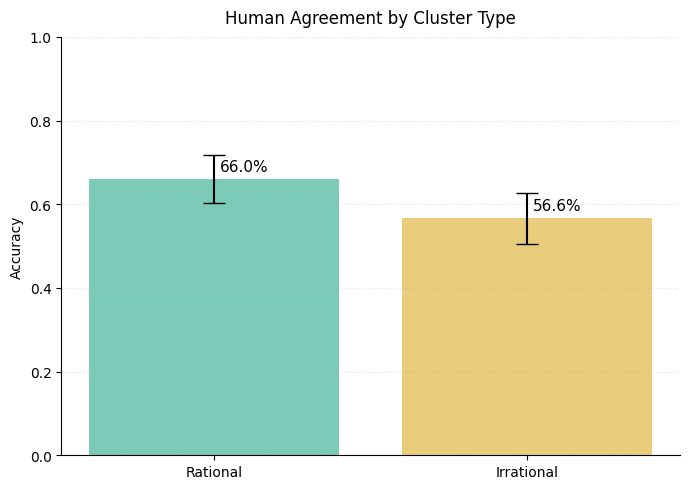

: 

In [ ]:
colors = ["#6EC6B2", "#E7C86E"]
labels = ["Rational", "Irrational"]

# Compute accuracies and 95% CIs
accuracies = [
    homogeneous_df["is_correct"].mean(),
    heterogeneous_df["is_correct"].mean(),
]

conf_intervals = []
for df_subset in [homogeneous_df, heterogeneous_df]:
    n = len(df_subset)
    p = df_subset["is_correct"].mean()
    se = np.sqrt(p * (1 - p) / n)
    ci_low, ci_high = stats.norm.interval(0.95, loc=p, scale=se)
    conf_intervals.append((p - ci_low, ci_high - p))

conf_intervals = np.array(conf_intervals).T

x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(7, 5))

bars = ax.bar(
    x,
    accuracies,
    yerr=conf_intervals,
    capsize=8,
    color=colors,
    edgecolor="none",
    alpha=0.90,
)

# Labels
ax.set_ylabel("Accuracy")
ax.set_title("Human Agreement by Cluster Type", pad=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)

# Annotate percentages
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.annotate(
        f"{acc:.1%}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(4, 4),
        textcoords="offset points",
        va="bottom",
        fontsize=11,
    )

# Aesthetic cleanup
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()